<a href="https://colab.research.google.com/github/siren7075/hackathon2024/blob/main/thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Anomalies for SPOT, sort by date and group by currency , then get percentile changes and their thresholds

In [11]:
import pandas as pd
from scipy import stats

# Load the CSV data
df = pd.read_csv('fx_rates_spot_forward_MID_3mo_fromUSD.csv')

# Filter the DataFrame for fxType "SPOT"
spot_df = df[df['fxType'] == 'SPOT']

# Group by currency and sort by effectiveDate
spot_df = spot_df.sort_values(by=['toCurrencyCode', 'effectiveDate'])

# Prepare a DataFrame to store anomalies and thresholds
anomalies = pd.DataFrame()

# Calculate percentage changes and thresholds for each currency group
for currency, group in spot_df.groupby('toCurrencyCode'):
    group['percentage_change'] = group['spotRate'].pct_change() * 100

    # Calculate mean and standard deviation of percentage changes
    mean_change = group['percentage_change'].mean()
    std_dev_change = group['percentage_change'].std()

    # Define thresholds using Z-score method
    k = 2  # Adjust k for strictness
    lower_threshold = mean_change - k * std_dev_change
    upper_threshold = mean_change + k * std_dev_change

    # Identify anomalies based on the thresholds
    group['anomaly'] = ((group['percentage_change'] < lower_threshold) |
                        (group['percentage_change'] > upper_threshold))

    # Store the thresholds in the group DataFrame
    group['lower_threshold'] = lower_threshold
    group['upper_threshold'] = upper_threshold

    # Append anomalies to the anomalies DataFrame
    anomalies = pd.concat([anomalies, group[group['anomaly']]])

# Display the results with thresholds
print("Dynamic Thresholds and Anomalies:")
print("Currencies with Anomalies and Their Effective Dates:")
anomaly_list = anomalies[['toCurrencyCode', 'effectiveDate']].drop_duplicates()
# for index, row in anomaly_list.iterrows():
#     print(f"Currency: {row['toCurrencyCode']}, Effective Date: {row['effectiveDate']}")
print(anomalies[['effectiveDate', 'toCurrencyCode', 'spotRate', 'percentage_change', 'lower_threshold', 'upper_threshold']])


Dynamic Thresholds and Anomalies:
Currencies with Anomalies and Their Effective Dates:
      effectiveDate toCurrencyCode   spotRate  percentage_change  \
2609     2024-09-18            AED     3.6730           0.002723   
7806     2024-10-04            AED     3.6731           0.002723   
8264     2024-10-07            AED     3.6732           0.002722   
8680     2024-10-08            AED     3.6731          -0.002722   
9134     2024-10-09            AED     3.6730          -0.002722   
...             ...            ...        ...                ...   
6057     2024-09-30            KRW  1307.7000          -0.796541   
7807     2024-10-04            KRW  1333.8000           1.095236   
8195     2024-10-07            KRW  1347.5000           1.027141   
17763    2024-11-06            KRW  1396.0500           1.262104   
27804    2024-12-09            KRW  1436.8000           1.240135   

       lower_threshold  upper_threshold  
2609         -0.002548         0.002674  
7806        

Plotting

<ipython-input-10-92981d39f46c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anomaly_counts, x='Currency', y='Anomaly Count', palette='viridis')


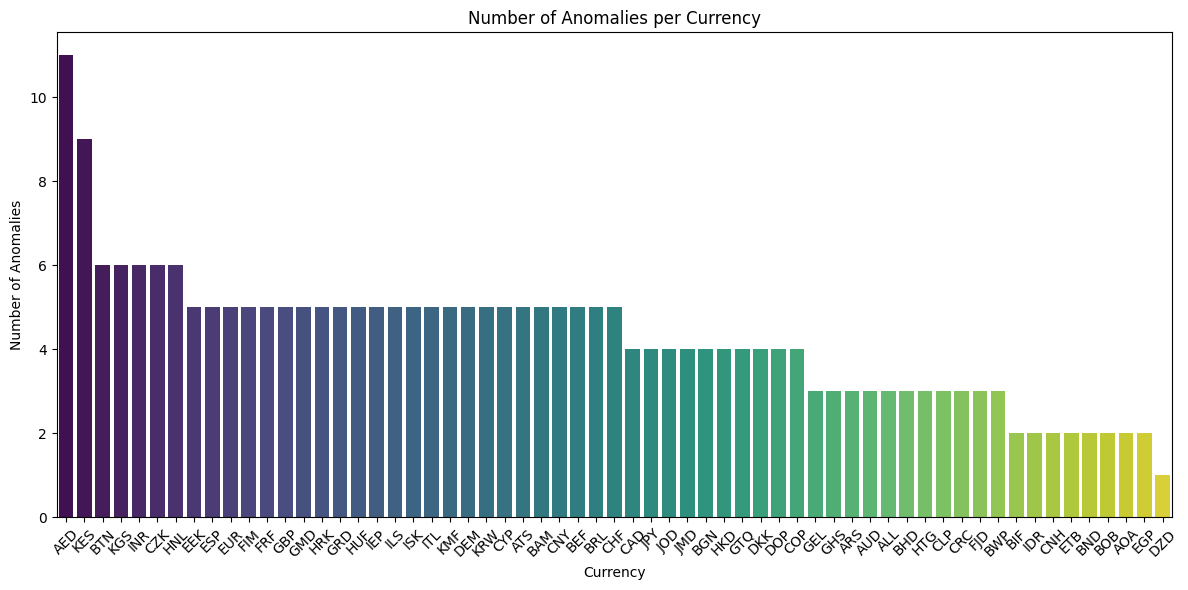

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count of anomalies per currency
anomaly_counts = anomaly_list['toCurrencyCode'].value_counts().reset_index()
anomaly_counts.columns = ['Currency', 'Anomaly Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=anomaly_counts, x='Currency', y='Anomaly Count', palette='viridis')
plt.title('Number of Anomalies per Currency')
plt.xlabel('Currency')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
